<a href="https://colab.research.google.com/github/hamednasr/TensorFlow-Projects/blob/main/Food_Vision_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 101 Food Vision Classification

## import libraries:

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt

## checking the GPU to see if it supports mixed precision

In [2]:
!nvidia-smi

Fri Aug 26 05:13:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-26 05:13:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-26 05:13:53 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys 

## Tensorflow Datasets

In [5]:
dataset_list = tfds.list_builders()
dataset_list [:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence']

## importing food 101 dataset

In [6]:
(train_data,test_data), ds_info = tfds.load('food101',
                                            split=['train','validation'],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True,
                                            batch_size=32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete5A5XCH/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete5A5XCH/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [8]:
for images , labels in test_data:
  print(images.shape, labels)
  break

(32, 512, 512, 3) tf.Tensor(
[44 27 79 16 51 12 17 99 13 42 24 54 36 80 26 68 83 16 60 32 36 94 48  0
 65 29 56 37 87 65 64 26], shape=(32,), dtype=int64)


(512, 512, 3) <dtype: 'uint8'>


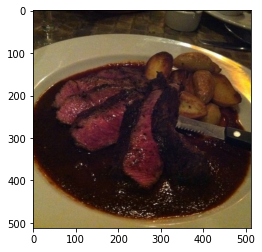

In [9]:
for image , label in test_data.take(1):
  img = image[0]
  print(img.shape, img.dtype)
  # print(tf.reduce_max(img))
  # img = tf.image.rot90(img, k=1)
  plt.imshow(img)


In [10]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [11]:
ds_info.supervised_keys

('image', 'label')

In [12]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [13]:
ds_info.features['image']

Image(shape=(None, None, 3), dtype=tf.uint8)

In [14]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [15]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [16]:
# def preprocess_img(image, image_size = 224):
#   new_image = tf.image.Resize(image, size= (image_size, image_size))
#   tf.cast(new_image, dtype = tf.float32)
#   return new_image 

In [17]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
train_data.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
for image , label in train_data.take(1):
  print(f'''shape: {image.shape}
  tyep: {image.dtype}
  label : {label}''')
  #class name : {class_names[label.numpy()]}''')

shape: (32, 512, 512, 3)
  tyep: <dtype: 'uint8'>
  label : [23 24  4  2 58 34 96 97 41 48 40 25 38 64  6 40 77  4 24 61 45 58 81 76
 66 33 21 51 47 84 54 61]


In [20]:
image[0]

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 54,  14,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       ...,

       [[108,  31,  49],
        [106,  29,  47],
        [105,  28,  46],
        ...,
        [121,  38,  56],
        [122,  39,  59],
        [123,  40,  60]],

       [[107,  30,  48],
        [107,  30,  48],
        [107,  30,  48],
        ...,
        [121,  38,  58],
        [123,  40,  60],
        [123,  40,  60]],

       [[106,  29,  47],
        [108,  31,  49],
        [109,  32,  50],
        ...,
        [123,  40,  6

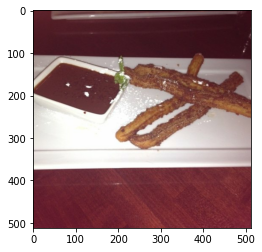

In [21]:
plt.imshow(image[0])

In [22]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## data augmentation

In [24]:
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.Resizing(224,224),
                    # tf.keras.layers.Rescaling(1/255), # efficientnet has built-in rescaling
                    tf.keras.layers.RandomFlip('horizontal'),
                    tf.keras.layers.RandomRotation(0.1)],
                    # tf.keras.layers.RandomZoom(0.2),
                    # tf.keras.layers.RandomHeight(0.2),
                    # tf.keras.layers.RandomWidth(0.2)], 
                    name ="data_augmentation")

## Model Callbacks

In [25]:
checkpointPath = '/checkpoint/FoodVision'
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(checkpointPath, 
                                                     monitor='val_acc', 
                                                     save_best_only=True,
                                                     save_weights_only=True)

## Turn on Mixed Precision mode

In [26]:
mixed_precision.set_global_policy('mixed_float16')

In [27]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Model Creation

In [35]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, pooling='avg')

inputs = tf.keras.layers.Input(shape=(224,224,3), name = 'input_layer')

x = data_augmentation(inputs)

x = base_model(x , training =False)

x =  tf.keras.layers.Dense(101)(x)

outputs = tf.keras.layers.Activation('softmax', dtype = tf.float32, name = 'softmax_float32')(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf .keras. optimizers.Adam(),
              metrics = ['accuracy'])

In [36]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-tra

In [37]:
for layer in model.layers:
  print(layer.name, layer.dtype , layer.dtype_policy)

input_layer float32 <Policy "float32">
data_augmentation float32 <Policy "float32">
efficientnetb0 float32 <Policy "mixed_float16">
dense_2 float32 <Policy "mixed_float16">
softmax_float32 float32 <Policy "float32">
